## 6 - Binary Relations

##### Imports

In [1]:
# Import
import os
import ast
import json
import pandas as pd
import numpy as np
import scipy as su
from collections import defaultdict
# from typing import Dict
# from scipy.signal import
# from scikit-learn import

from matplotlib.path import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import dask.dataframe as dd

import pingouin as pg
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
import scipy.stats as stats
import pingouin as pg
from scipy.stats import ttest_rel, wilcoxon
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import boxcox
from scipy.stats import friedmanchisquare
from scipy.stats import levene
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

##### Data Loading (AoI)

In [3]:
# Load AoI ddfs into dictionary
root_dir = './aoi_data'
def load_aoi_data(root_dir): # Get csv file reads into one dictionary
    data = {}
    for file in os.listdir(root_dir):
        file_path = os.path.join(root_dir, file)
        file_name = os.path.splitext(file)[0]  # file name without '.csv'
        data[file_name] = dd.read_csv(file_path)  # read and attach to dict
    return data

data = load_aoi_data(root_dir)
participant_ids = [1,2,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20]

In [4]:
# AoI features (task based)
def convert_to_list(value):
    value = value.replace('nan', 'null')
    result = json.loads(value)
    result = [np.nan if x is None else x for x in result]
    return result

df = pd.read_csv('aoi_data/aoi_features.csv', converters={
    'duration': convert_to_list,
    'fix_count': convert_to_list,
    'fix_freq': convert_to_list,
    'time_1st_fix': convert_to_list,
    'visit_count': convert_to_list,
    'visit_freq': convert_to_list,
    'visit_len': convert_to_list,
    'dwell_pct': convert_to_list,
    'stat_entropy': convert_to_list,
    'trans_entropy': convert_to_list,
})

df['condition'] =  df['difficulty'] + ' ' + df['frequency']

rel_cols = ['participant_id',
 'condition',
 'area',
 'instance',
 'duration',
 'fix_count',
 'fix_freq',
 'time_1st_fix',
 'visit_count',
 'visit_freq',
 'visit_len',
 'dwell_pct',
 'stat_entropy',
 'trans_entropy'
 ]
df = df[rel_cols].reset_index(drop=True)

In [5]:
# Easy Slow vs Hard Fast
df = df.query("condition == 'Easy Slow' or condition == 'Hard Fast'")

In [6]:
# Pivot df
list_columns = [
 'duration',
 'fix_count',
 'fix_freq',
 'time_1st_fix',
 'visit_count',
 'visit_freq',
 'visit_len',
 'dwell_pct',
]
df_pivot = df.pivot_table(index=['participant_id', 'condition', 'instance'],
                          columns='area',
                          values=list_columns,
                          aggfunc='first').reset_index()
df_pivot.columns = [col[0] if col[1] == '' else f"{col[0]}_{col[1]}" for col in df_pivot.columns]

col_order = [
    'participant_id',
    'condition',
    'instance',
    'duration_Ticket',
    'duration_Description',
    'duration_Map',
    'duration_Diagnostics',
    'duration_Actions',
    'fix_count_Ticket',
    'fix_count_Description',
    'fix_count_Map',
    'fix_count_Diagnostics',
    'fix_count_Actions',
    'fix_freq_Ticket',
    'fix_freq_Description',
    'fix_freq_Map',
    'fix_freq_Diagnostics',
    'fix_freq_Actions',
    'time_1st_fix_Ticket',
    'time_1st_fix_Description',
    'time_1st_fix_Map',
    'time_1st_fix_Diagnostics',
    'time_1st_fix_Actions',
    'visit_count_Ticket',
    'visit_count_Description',
    'visit_count_Map',
    'visit_count_Diagnostics',
    'visit_count_Actions',
    'visit_freq_Ticket',
    'visit_freq_Description',
    'visit_freq_Map',
    'visit_freq_Diagnostics',
    'visit_freq_Actions',
    'visit_len_Ticket',
    'visit_len_Description',
    'visit_len_Map',
    'visit_len_Diagnostics',
    'visit_len_Actions',
    'dwell_pct_Ticket',
    'dwell_pct_Description',
    'dwell_pct_Map',
    'dwell_pct_Diagnostics',
    'dwell_pct_Actions',
]
df_pivot = df_pivot[col_order]

entropy_columns = ['participant_id', 'condition', 'instance', 'stat_entropy', 'trans_entropy']
unique_entropy_df = df[entropy_columns].drop_duplicates(subset=['participant_id', 'condition', 'instance'])

df_long = pd.merge(df_pivot, unique_entropy_df, on=['participant_id', 'condition', 'instance'], how='left')

In [7]:
# Explode lists
list_columns = [
    'duration_Ticket',
    'duration_Description',
    'duration_Map',
    'duration_Diagnostics',
    'duration_Actions',
    'fix_count_Ticket',
    'fix_count_Description',
    'fix_count_Map',
    'fix_count_Diagnostics',
    'fix_count_Actions',
    'fix_freq_Ticket',
    'fix_freq_Description',
    'fix_freq_Map',
    'fix_freq_Diagnostics',
    'fix_freq_Actions',
    'time_1st_fix_Ticket',
    'time_1st_fix_Description',
    'time_1st_fix_Map',
    'time_1st_fix_Diagnostics',
    'time_1st_fix_Actions',
    'visit_count_Ticket',
    'visit_count_Description',
    'visit_count_Map',
    'visit_count_Diagnostics',
    'visit_count_Actions',
    'visit_freq_Ticket',
    'visit_freq_Description',
    'visit_freq_Map',
    'visit_freq_Diagnostics',
    'visit_freq_Actions',
    'visit_len_Ticket',
    'visit_len_Description',
    'visit_len_Map',
    'visit_len_Diagnostics',
    'visit_len_Actions',
    'dwell_pct_Ticket',
    'dwell_pct_Description',
    'dwell_pct_Map',
    'dwell_pct_Diagnostics',
    'dwell_pct_Actions',
    'stat_entropy',
    'trans_entropy'
]
def explode_row(row, list_columns):
    num_elements = len(row[list_columns[0]])
    expanded_rows = pd.DataFrame({
        col: [row[col]] * num_elements if col not in list_columns else row[col]
        for col in row.index
    })
    return expanded_rows
df_long_expanded = pd.concat(df_long.apply(explode_row, list_columns=list_columns, axis=1).values).reset_index(drop=True)

### 1. AoI Selection per Metric

##### Fixation Duration
Description

In [8]:
# Prepare variables
features = [
    'duration_Ticket',
    'duration_Description',
    'duration_Map',
    'duration_Diagnostics',
    'duration_Actions'
]

X = df_long_expanded.dropna()[features]
y = df_long_expanded.dropna()['condition'].apply(lambda x: 0 if x == "Easy Slow" else 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

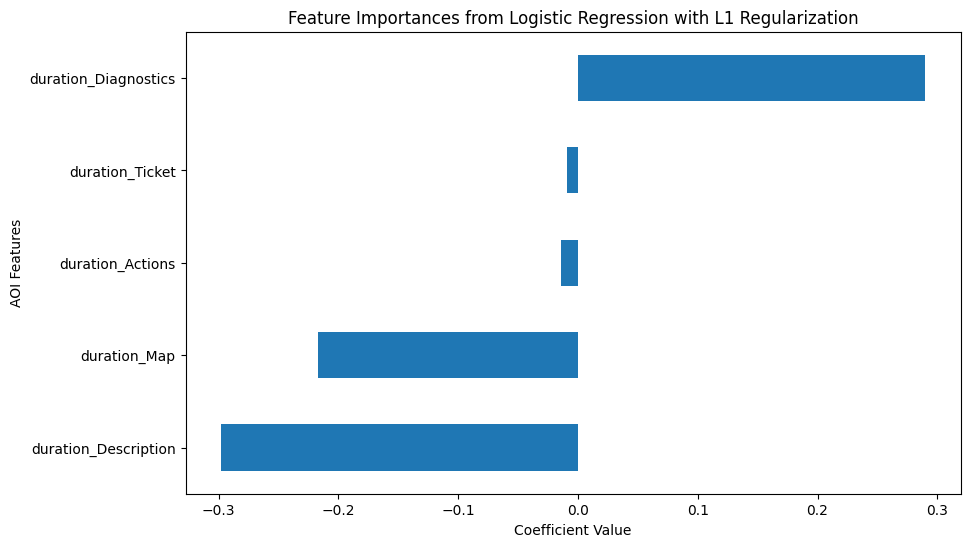

In [9]:
# Fit model and plot feature importances
log_reg = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=3)
log_reg.fit(X_scaled, y)

feature_importance = pd.Series(log_reg.coef_[0], index=X.columns)
feature_importance = feature_importance.sort_values(ascending=True)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='barh')
plt.title('Feature Importances from Logistic Regression with L1 Regularization')
plt.xlabel('Coefficient Value')
plt.ylabel('AOI Features')
plt.show()

##### Fixation Count
Description

In [10]:
# Prepare variables
features = [
    'fix_count_Ticket',
    'fix_count_Description',
    'fix_count_Map',
    'fix_count_Diagnostics',
    'fix_count_Actions'
]

X = df_long_expanded.dropna().drop(columns=['participant_id', 'instance', 'condition'])[features]
y = df_long_expanded.dropna()['condition'].apply(lambda x: 0 if x == "Easy Slow" else 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

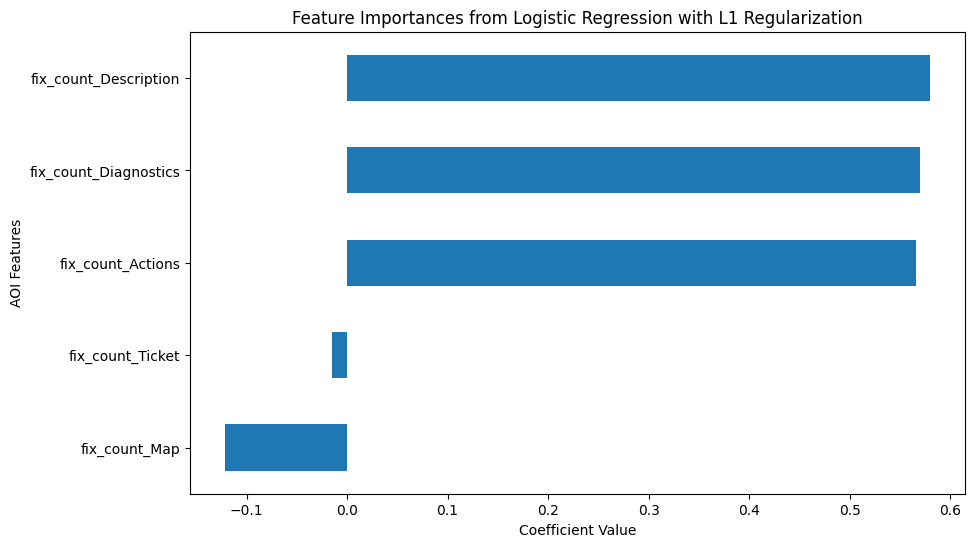

In [11]:
# Fit model and plot feature importances
log_reg = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=0)
log_reg.fit(X_scaled, y)

feature_importance = pd.Series(log_reg.coef_[0], index=X.columns)
feature_importance = feature_importance.sort_values(ascending=True)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='barh')
plt.title('Feature Importances from Logistic Regression with L1 Regularization')
plt.xlabel('Coefficient Value')
plt.ylabel('AOI Features')
plt.show()

##### Fixation Frequency
Actions

In [12]:
# Prepare variables
features = [
    'fix_freq_Ticket',
    'fix_freq_Description',
    'fix_freq_Map',
    'fix_freq_Diagnostics',
    'fix_freq_Actions'
]

X = df_long_expanded.dropna().drop(columns=['participant_id', 'instance', 'condition'])[features]
y = df_long_expanded.dropna()['condition'].apply(lambda x: 0 if x == "Easy Slow" else 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

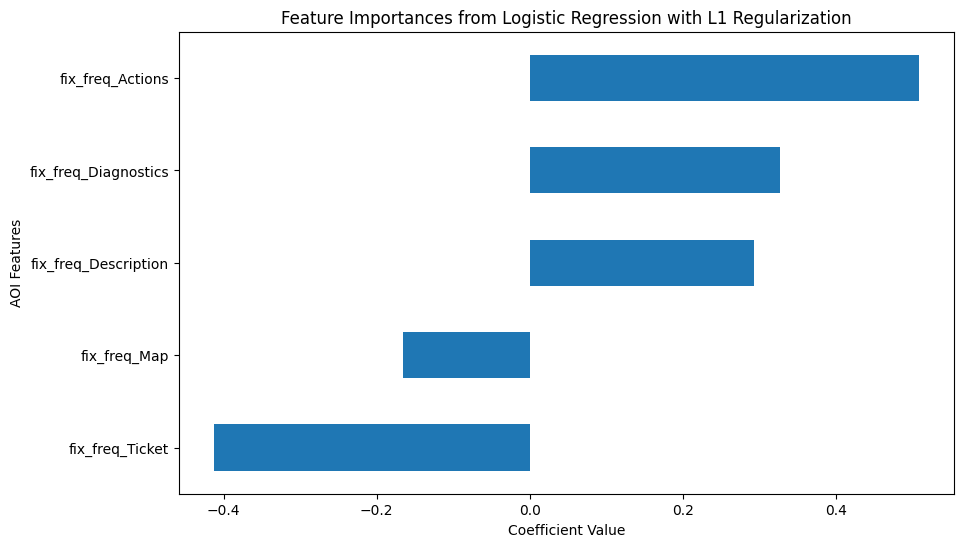

In [13]:
# Fit model and plot feature importances
log_reg = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=0)
log_reg.fit(X_scaled, y)

feature_importance = pd.Series(log_reg.coef_[0], index=X.columns)
feature_importance = feature_importance.sort_values(ascending=True)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='barh')
plt.title('Feature Importances from Logistic Regression with L1 Regularization')
plt.xlabel('Coefficient Value')
plt.ylabel('AOI Features')
plt.show()

##### Time-to-1st Fixation
Actions

In [14]:
# Prepare variables
features = [
    'time_1st_fix_Ticket',
    'time_1st_fix_Description',
    'time_1st_fix_Map',
    'time_1st_fix_Diagnostics',
    'time_1st_fix_Actions'
]

X = df_long_expanded.dropna().drop(columns=['participant_id', 'instance', 'condition'])[features]
y = df_long_expanded.dropna()['condition'].apply(lambda x: 0 if x == "Easy Slow" else 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

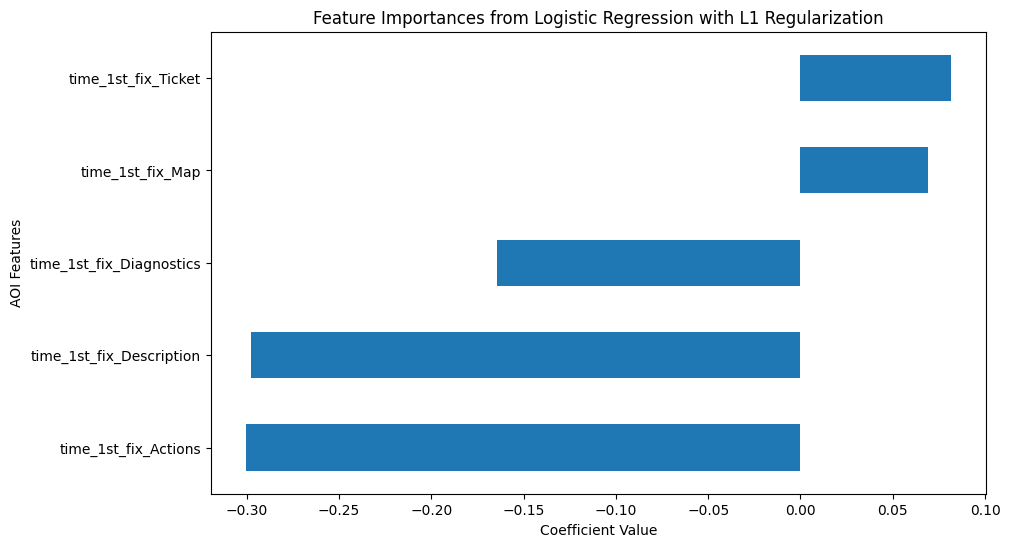

In [15]:
# Fit model and plot feature importances
log_reg = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=0)
log_reg.fit(X_scaled, y)

feature_importance = pd.Series(log_reg.coef_[0], index=X.columns)
feature_importance = feature_importance.sort_values(ascending=True)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='barh')
plt.title('Feature Importances from Logistic Regression with L1 Regularization')
plt.xlabel('Coefficient Value')
plt.ylabel('AOI Features')
plt.show()

##### Visit Count
Diagnostics

In [16]:
# Prepare variables
features = [
    'visit_count_Ticket',
    'visit_count_Description',
    'visit_count_Map',
    'visit_count_Diagnostics',
    'visit_count_Actions'
]

X = df_long_expanded.dropna().drop(columns=['participant_id', 'instance', 'condition'])[features]
y = df_long_expanded.dropna()['condition'].apply(lambda x: 0 if x == "Easy Slow" else 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

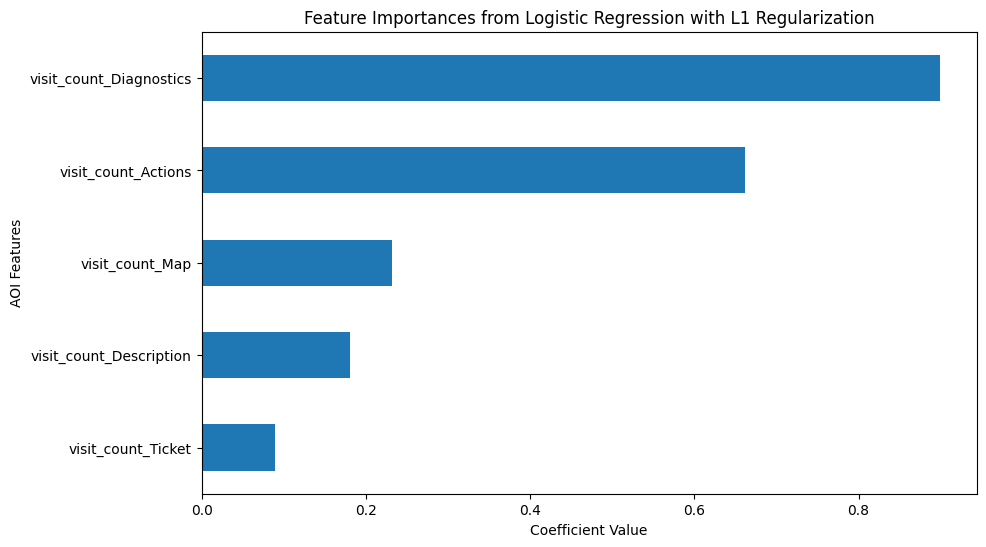

In [17]:
# Fit model and plot feature importances
log_reg = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=0)
log_reg.fit(X_scaled, y)

feature_importance = pd.Series(log_reg.coef_[0], index=X.columns)
feature_importance = feature_importance.sort_values(ascending=True)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='barh')
plt.title('Feature Importances from Logistic Regression with L1 Regularization')
plt.xlabel('Coefficient Value')
plt.ylabel('AOI Features')
plt.show()

##### Visit Frequency
Ticket

In [18]:
# Prepare variables
features = [
    'visit_freq_Ticket',
    'visit_freq_Description',
    'visit_freq_Map',
    'visit_freq_Diagnostics',
    'visit_freq_Actions'
]

X = df_long_expanded.dropna().drop(columns=['participant_id', 'instance', 'condition'])[features]
y = df_long_expanded.dropna()['condition'].apply(lambda x: 0 if x == "Easy Slow" else 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

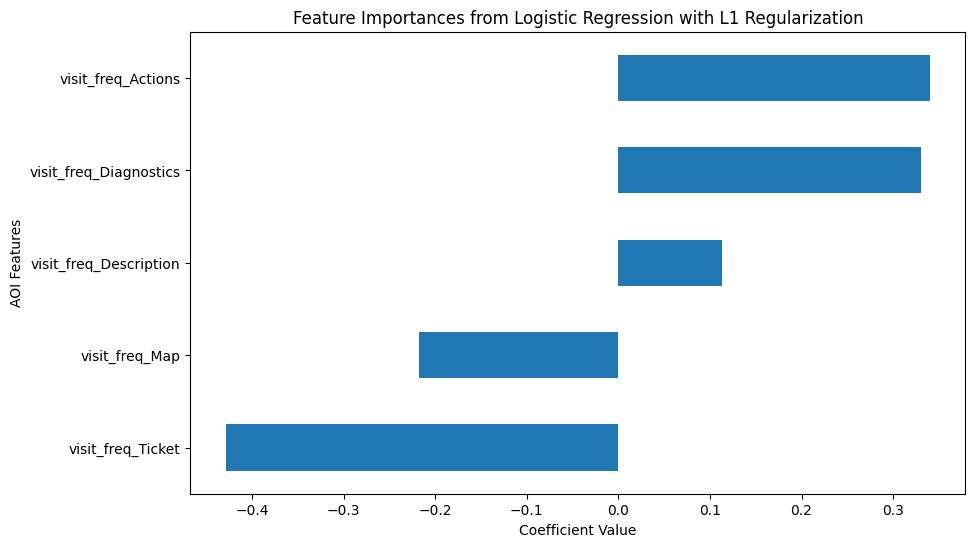

In [19]:
# Fit model and plot feature importances
log_reg = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=0)
log_reg.fit(X_scaled, y)

feature_importance = pd.Series(log_reg.coef_[0], index=X.columns)
feature_importance = feature_importance.sort_values(ascending=True)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='barh')
plt.title('Feature Importances from Logistic Regression with L1 Regularization')
plt.xlabel('Coefficient Value')
plt.ylabel('AOI Features')
plt.show()

##### Visit Length
Description

In [20]:
# Prepare variables
features = [
    'visit_len_Ticket',
    'visit_len_Description',
    'visit_len_Map',
    'visit_len_Diagnostics',
    'visit_len_Actions'
]

X = df_long_expanded.dropna().drop(columns=['participant_id', 'instance', 'condition'])[features]
y = df_long_expanded.dropna()['condition'].apply(lambda x: 0 if x == "Easy Slow" else 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

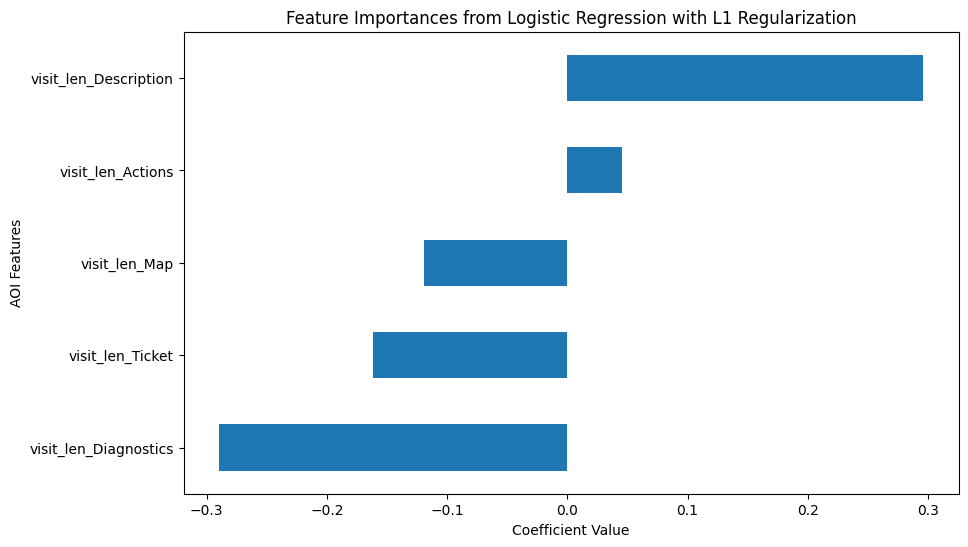

In [21]:
# Fit model and plot feature importances
log_reg = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=0)
log_reg.fit(X_scaled, y)

feature_importance = pd.Series(log_reg.coef_[0], index=X.columns)
feature_importance = feature_importance.sort_values(ascending=True)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='barh')
plt.title('Feature Importances from Logistic Regression with L1 Regularization')
plt.xlabel('Coefficient Value')
plt.ylabel('AOI Features')
plt.show()

##### Dwell Time
Ticket

In [22]:
# Prepare variables
features = [
    'dwell_pct_Ticket',
    'dwell_pct_Description',
    'dwell_pct_Map',
    'dwell_pct_Diagnostics',
    'dwell_pct_Actions'
]

X = df_long_expanded.dropna().drop(columns=['participant_id', 'instance', 'condition'])[features]
y = df_long_expanded.dropna()['condition'].apply(lambda x: 0 if x == "Easy Slow" else 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

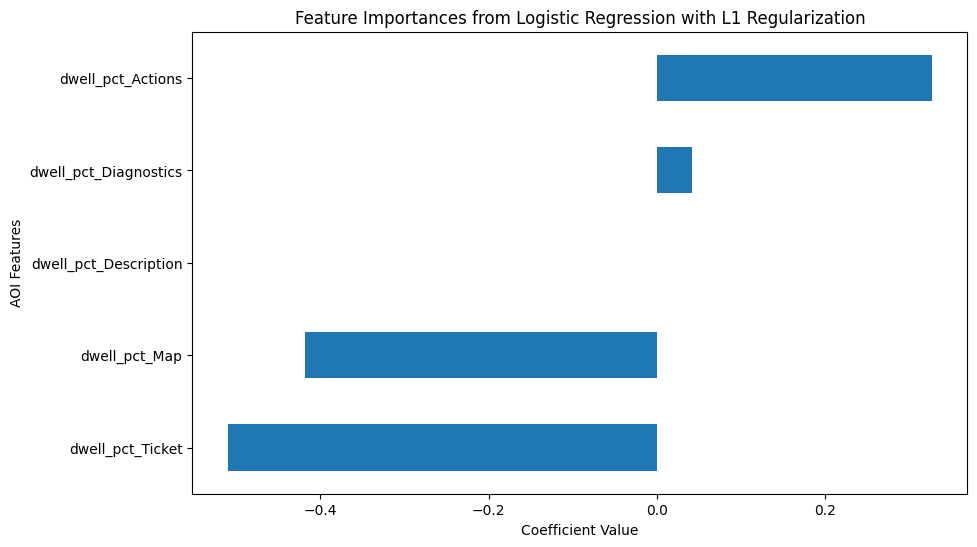

In [23]:
# Fit model and plot feature importances
log_reg = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=0)
log_reg.fit(X_scaled, y)

feature_importance = pd.Series(log_reg.coef_[0], index=X.columns)
feature_importance = feature_importance.sort_values(ascending=True)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='barh')
plt.title('Feature Importances from Logistic Regression with L1 Regularization')
plt.xlabel('Coefficient Value')
plt.ylabel('AOI Features')
plt.show()

##### Entropy
Transition Entropy

In [24]:
# Prepare variables
features = [
    'stat_entropy',
    'trans_entropy'
]

X = df_long_expanded.dropna().drop(columns=['participant_id', 'instance', 'condition'])[features]
y = df_long_expanded.dropna()['condition'].apply(lambda x: 0 if x == "Easy Slow" else 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

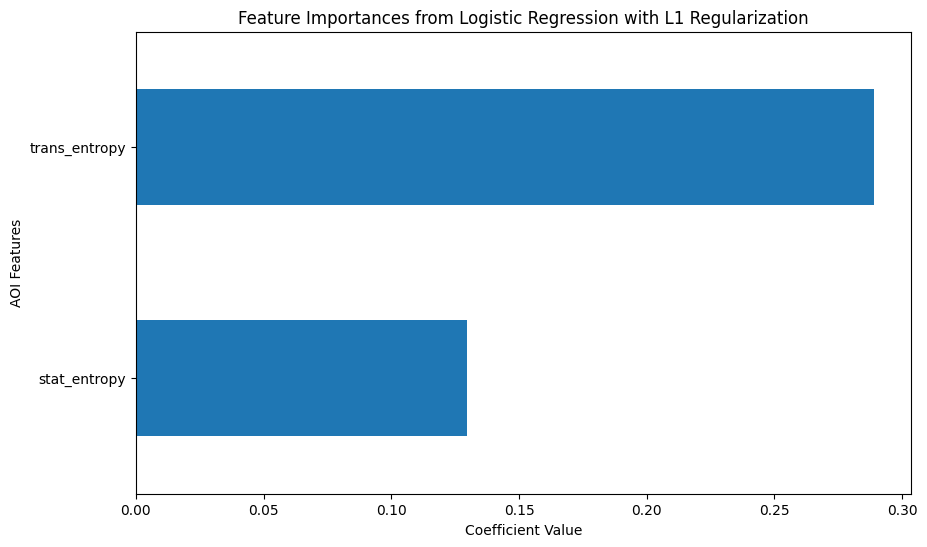

In [25]:
# Fit model and plot feature importances
log_reg = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=0)
log_reg.fit(X_scaled, y)

feature_importance = pd.Series(log_reg.coef_[0], index=X.columns)
feature_importance = feature_importance.sort_values(ascending=True)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='barh')
plt.title('Feature Importances from Logistic Regression with L1 Regularization')
plt.xlabel('Coefficient Value')
plt.ylabel('AOI Features')
plt.show()

### 2. Descriptive Analysis

##### Fixation Duration - Description
Negative *

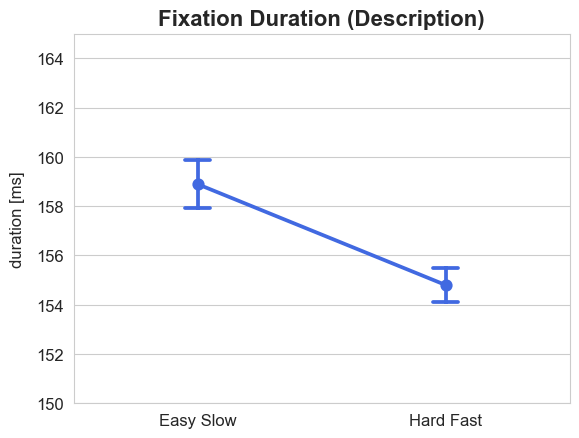

In [26]:
# Visualize plot
sns.set_style("whitegrid")
col = 'duration_Description'
plt.title('Fixation Duration (Description)', fontsize=16, weight='bold')

sns.pointplot(data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color='#4169E1')
plt.xlabel('')
plt.ylabel('duration [ms]', fontsize=12, labelpad=8)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.ylim(150, 165)
plt.xticks(ticks=[0, 1], labels=['Easy Slow', 'Hard Fast'])
plt.show()

##### Fixation Count - Description
Positive -

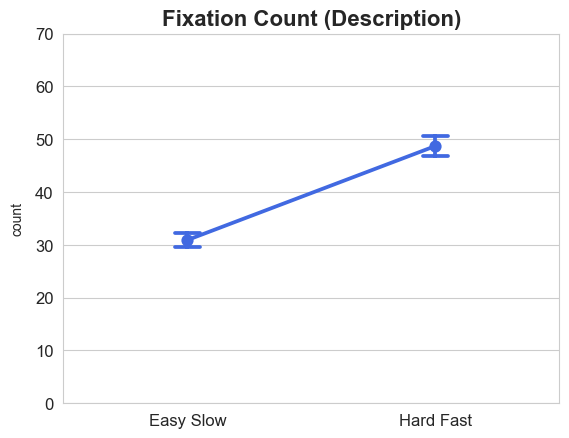

In [27]:
# Visualize plot
col = 'fix_count_Description'
plt.title('Fixation Count (Description)', fontsize=16, weight='bold')
sns.set_style("whitegrid")

sns.pointplot(data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color='#4169E1')
plt.xlabel('')
plt.ylabel('count', fontsize=10, labelpad=8)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.ylim(0, 70)
plt.xticks(ticks=[0, 1], labels=['Easy Slow', 'Hard Fast'])
plt.show()

##### Fixation Frequency - Actions
Positive

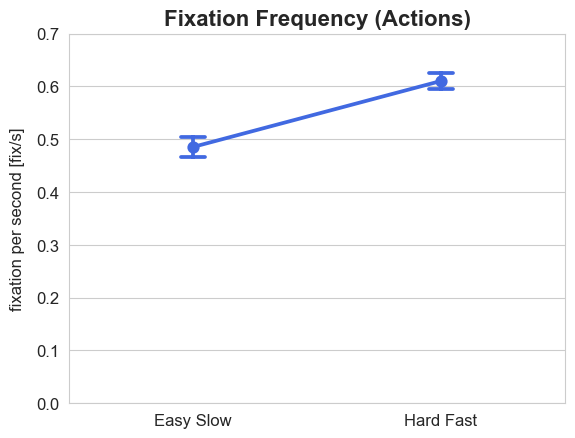

In [28]:
# Visualize plot
col = 'fix_freq_Actions'
plt.title('Fixation Frequency (Actions)', fontsize=16, weight='bold')
sns.set_style("whitegrid")

sns.pointplot(data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color='#4169E1')
plt.xlabel('')
plt.ylabel('fixation per second [fix/s]', fontsize=12, labelpad=8)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.ylim(0, 0.7)
plt.xticks(ticks=[0, 1], labels=['Easy Slow', 'Hard Fast'])
plt.show()

##### Time-to-1st- Fix - Actions
Negative *

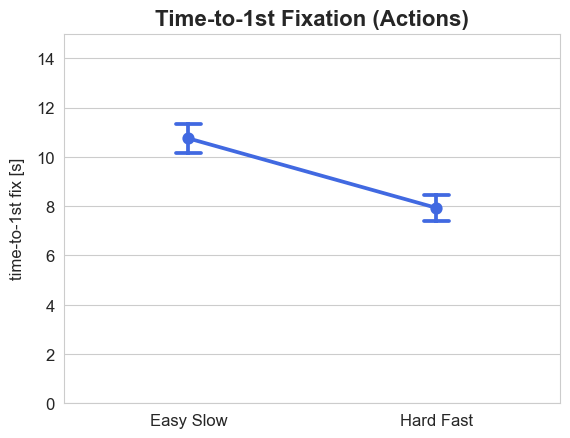

In [29]:
# Visualize plot
col = 'time_1st_fix_Actions'
plt.title('Time-to-1st Fixation (Actions)', fontsize=16, weight='bold')
sns.set_style("whitegrid")

sns.pointplot(data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color='#4169E1')
plt.xlabel('')
plt.ylabel('time-to-1st fix [s]', fontsize=12, labelpad=8)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.ylim(0, 15)
plt.xticks(ticks=[0, 1], labels=['Easy Slow', 'Hard Fast'])
plt.show()

##### Visit Count - Diagnostics
Positive *

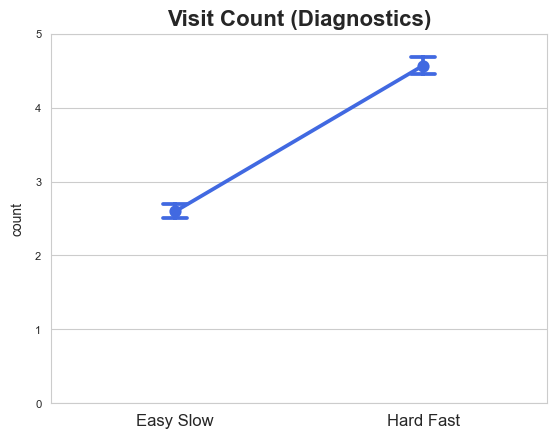

In [30]:
# Visualize plot
col = 'visit_count_Diagnostics'
plt.title('Visit Count (Diagnostics)', fontsize=16, weight='bold')
sns.set_style("whitegrid")

sns.pointplot(data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color='#4169E1')
plt.xlabel('')
plt.ylabel('count', fontsize=10, labelpad=8)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=8)
plt.ylim(0, 5)
plt.xticks(ticks=[0, 1], labels=['Easy Slow', 'Hard Fast'])
plt.show()

##### Visit Frequency - Ticket
Negative *

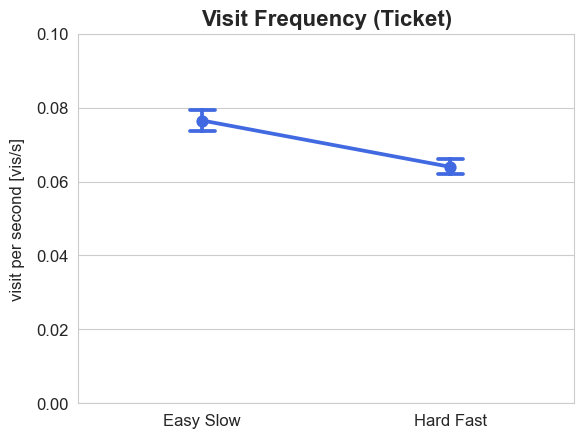

In [31]:
# Visualize plot
col = 'visit_freq_Ticket'
plt.title('Visit Frequency (Ticket)', fontsize=16, weight='bold')
sns.set_style("whitegrid")

sns.pointplot(data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color='#4169E1')
plt.xlabel('')
plt.ylabel('visit per second [vis/s]', fontsize=12, labelpad=8)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.ylim(0, .1)
plt.xticks(ticks=[0, 1], labels=['Easy Slow', 'Hard Fast'])
plt.show()

##### Visit Length - Description
Positive -

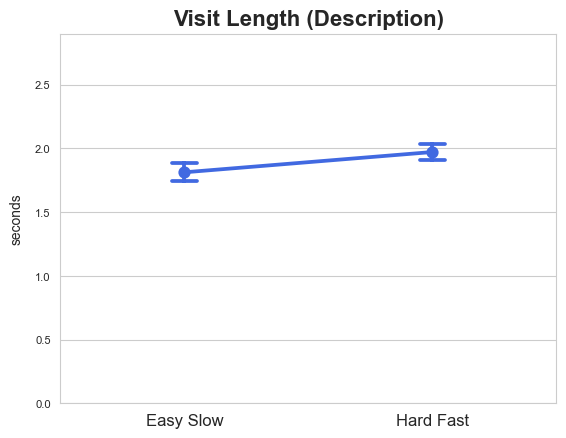

In [32]:
# Visualize plot
col = 'visit_len_Description'
plt.title('Visit Length (Description)', fontsize=16, weight='bold')
sns.set_style("whitegrid")

sns.pointplot(data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color='#4169E1')
plt.xlabel('')
plt.ylabel('seconds', fontsize=10, labelpad=8)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=8)
plt.ylim(0, 2.9)
plt.xticks(ticks=[0, 1], labels=['Easy Slow', 'Hard Fast'])
plt.show()

##### Dwell Time - Ticket
Negative *

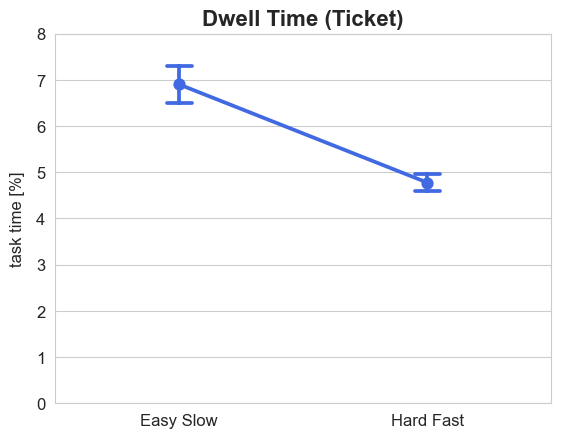

In [33]:
# Visualize plot
col = 'dwell_pct_Ticket'
plt.title('Dwell Time (Ticket)', fontsize=16, weight='bold')
sns.set_style("whitegrid")

sns.pointplot(data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color='#4169E1')
plt.xlabel('')
plt.ylabel('task time [%]', fontsize=12, labelpad=8)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.ylim(0, 8)
plt.xticks(ticks=[0, 1], labels=['Easy Slow', 'Hard Fast'])
plt.show()

##### Stationary Entropy
Positive *

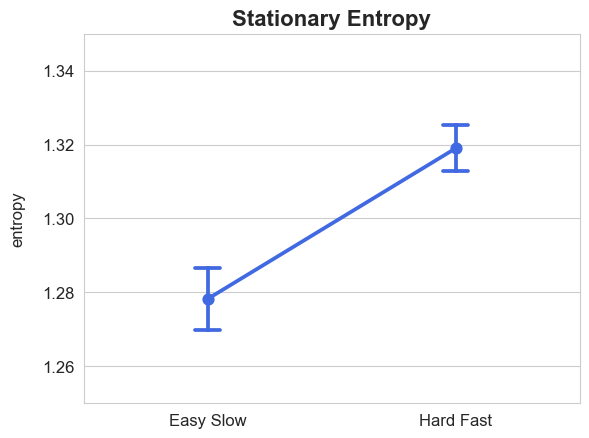

In [34]:
# Visualize plot
col = 'stat_entropy'
plt.title('Stationary Entropy', fontsize=16, weight='bold')
sns.set_style("whitegrid")

sns.pointplot(data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color='#4169E1')
plt.xlabel('')
plt.ylabel('entropy', fontsize=12, labelpad=12)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.ylim(1.25, 1.35)
plt.xticks(ticks=[0, 1], labels=['Easy Slow', 'Hard Fast'])
plt.show()

### 3. Inferential Analysis (two-sided)

##### Fixation Duration - Description
Significant

In [35]:
# Prepare Dataset
col = 'duration_Description'
aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'instance'])[col].mean().reset_index()
pivoted_df = aggregated_df.pivot(index=['participant_id', 'instance'], columns='condition', values=col).reset_index()
pivoted_df.columns.name = ''

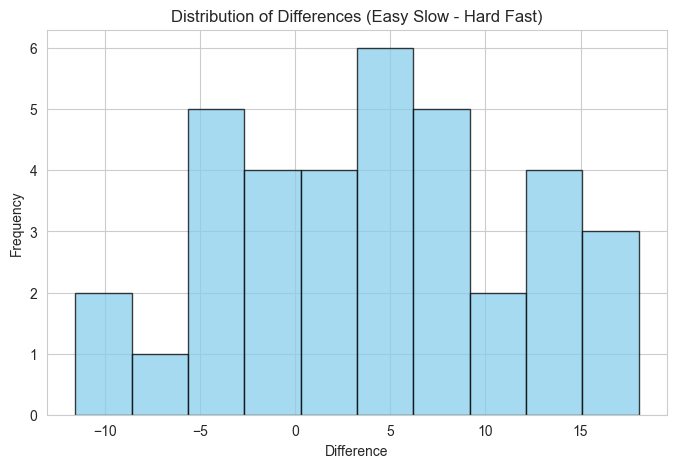

Shapiro-Wilk Test for Normality
Statistic = 0.9839, p-value = 0.8665


In [36]:
# Check Normality
pivoted_df['difference'] = pivoted_df['Easy Slow'] - pivoted_df['Hard Fast']

plt.figure(figsize=(8, 5))
plt.hist(pivoted_df['difference'], bins=10, alpha=0.75, color='skyblue', edgecolor='black')
plt.title('Distribution of Differences (Easy Slow - Hard Fast)')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

stat, p_value = stats.shapiro(pivoted_df['difference'])
print("Shapiro-Wilk Test for Normality")
print(f"Statistic = {stat:.4f}, p-value = {p_value:.4f}")

In [37]:
# Paired t-tests
dur_stat, dur_p_value = ttest_rel(pivoted_df['Easy Slow'], pivoted_df['Hard Fast'])
print(f"Paired t-test Results:\nt-statistic = {dur_stat:.4f}, p-value = {dur_p_value}")

Paired t-test Results:
t-statistic = 3.2783, p-value = 0.002364612366932171


##### Fixation Count - Description
Significant

In [38]:
# Prepare Dataset
col = 'fix_count_Description'
aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'instance'])[col].mean().reset_index()
pivoted_df = aggregated_df.pivot(index=['participant_id', 'instance'], columns='condition', values=col).reset_index()
pivoted_df.columns.name = ''

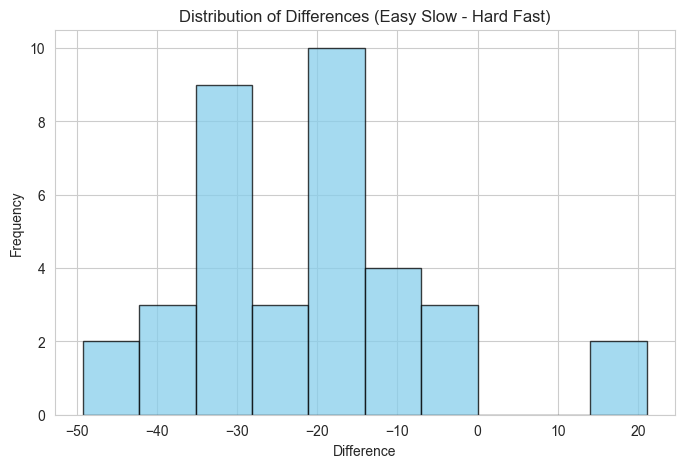

Shapiro-Wilk Test for Normality
Statistic = 0.9446, p-value = 0.0708


In [39]:
# Check Normality
pivoted_df['difference'] = pivoted_df['Easy Slow'] - pivoted_df['Hard Fast']

plt.figure(figsize=(8, 5))
plt.hist(pivoted_df['difference'], bins=10, alpha=0.75, color='skyblue', edgecolor='black')
plt.title('Distribution of Differences (Easy Slow - Hard Fast)')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

stat, p_value = stats.shapiro(pivoted_df['difference'])
print("Shapiro-Wilk Test for Normality")
print(f"Statistic = {stat:.4f}, p-value = {p_value:.4f}")

In [40]:
# Paired t-tests
fixc_stat, fixc_p_value = ttest_rel(pivoted_df['Easy Slow'], pivoted_df['Hard Fast'])
print(f"Paired t-test Results:\nt-statistic = {fixc_stat:.4f}, p-value = {fixc_p_value}")

Paired t-test Results:
t-statistic = -8.1151, p-value = 1.4785513590934972e-09


##### Fixation Frequency - Actions
Significant

In [41]:
# Prepare Dataset
col = 'fix_freq_Actions'
aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'instance'])[col].mean().reset_index()
pivoted_df = aggregated_df.pivot(index=['participant_id', 'instance'], columns='condition', values=col).reset_index()
pivoted_df.columns.name = ''

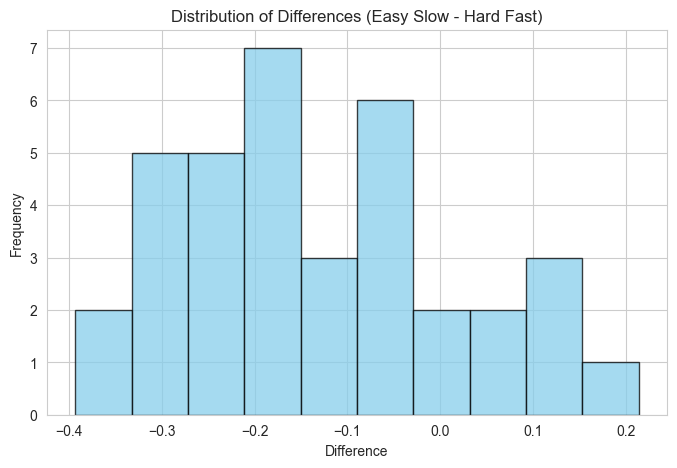

Shapiro-Wilk Test for Normality
Statistic = 0.9772, p-value = 0.6497


In [42]:
# Check Normality
pivoted_df['difference'] = pivoted_df['Easy Slow'] - pivoted_df['Hard Fast']

plt.figure(figsize=(8, 5))
plt.hist(pivoted_df['difference'], bins=10, alpha=0.75, color='skyblue', edgecolor='black')
plt.title('Distribution of Differences (Easy Slow - Hard Fast)')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

stat, p_value = stats.shapiro(pivoted_df['difference'])
print("Shapiro-Wilk Test for Normality")
print(f"Statistic = {stat:.4f}, p-value = {p_value:.4f}")

In [43]:
# Paired t-tests
fixf_stat, fixf_p_value = ttest_rel(pivoted_df['Easy Slow'], pivoted_df['Hard Fast'])
print(f"Paired t-test Results:\nt-statistic = {fixf_stat:.4f}, p-value = {fixf_p_value}")

Paired t-test Results:
t-statistic = -5.3536, p-value = 5.496509635240042e-06


##### Time-to-1st Fix - Actions
Not significant

In [44]:
# Prepare Dataset
col = 'time_1st_fix_Actions'
aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'instance'])[col].mean().reset_index()
pivoted_df = aggregated_df.pivot(index=['participant_id', 'instance'], columns='condition', values=col).reset_index()
pivoted_df.columns.name = ''

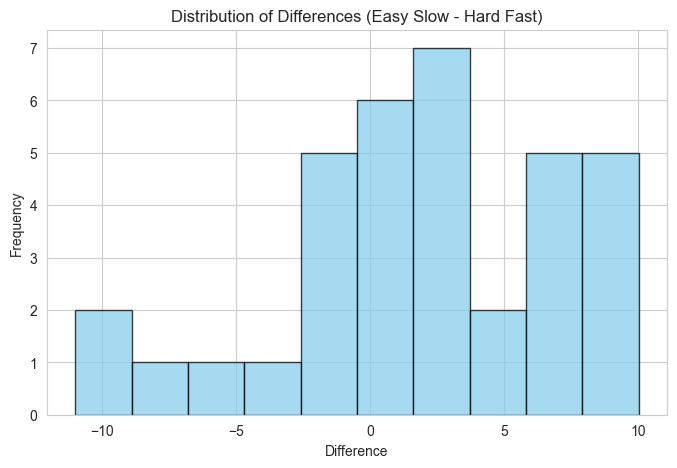

Shapiro-Wilk Test for Normality
Statistic = 0.9526, p-value = 0.1362


In [45]:
# Check Normality
pivoted_df['difference'] = pivoted_df['Easy Slow'] - pivoted_df['Hard Fast']
pivoted_df = pivoted_df[abs(pivoted_df['difference']) <= 20]

plt.figure(figsize=(8, 5))
plt.hist(pivoted_df['difference'], bins=10, alpha=0.75, color='skyblue', edgecolor='black')
plt.title('Distribution of Differences (Easy Slow - Hard Fast)')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

stat, p_value = stats.shapiro(pivoted_df['difference'])
print("Shapiro-Wilk Test for Normality")
print(f"Statistic = {stat:.4f}, p-value = {p_value:.4f}")

In [46]:
# Paired t-tests
ttff_stat, ttff_p_value = ttest_rel(pivoted_df['Easy Slow'], pivoted_df['Hard Fast'])
print(f"Paired t-test Results:\nt-statistic = {ttff_stat:.4f}, p-value = {ttff_p_value}")

Paired t-test Results:
t-statistic = 2.0247, p-value = 0.05080775702458401


##### Visit Count - Diagnostics
Significant

In [47]:
# Prepare Dataset
col = 'visit_count_Diagnostics'
aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'instance'])[col].mean().reset_index()
pivoted_df = aggregated_df.pivot(index=['participant_id', 'instance'], columns='condition', values=col).reset_index()
pivoted_df.columns.name = ''

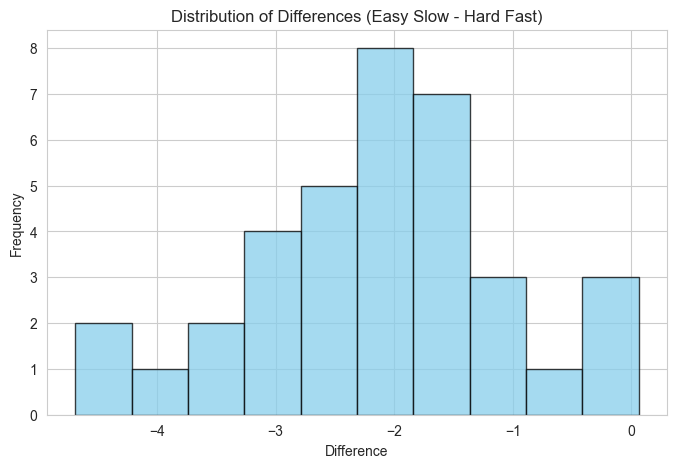

Shapiro-Wilk Test for Normality
Statistic = 0.9758, p-value = 0.6033


In [48]:
# Check Normality
pivoted_df['difference'] = pivoted_df['Easy Slow'] - pivoted_df['Hard Fast']

plt.figure(figsize=(8, 5))
plt.hist(pivoted_df['difference'], bins=10, alpha=0.75, color='skyblue', edgecolor='black')
plt.title('Distribution of Differences (Easy Slow - Hard Fast)')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

stat, p_value = stats.shapiro(pivoted_df['difference'])
print("Shapiro-Wilk Test for Normality")
print(f"Statistic = {stat:.4f}, p-value = {p_value:.4f}")

In [49]:
# Paired t-tests
visc_stat, visc_p_value = ttest_rel(pivoted_df['Easy Slow'], pivoted_df['Hard Fast'])
print(f"Paired t-test Results:\nt-statistic = {visc_stat:.4f}, p-value = {visc_p_value}")

Paired t-test Results:
t-statistic = -11.3240, p-value = 2.9724924373964614e-13


##### Visit Frequency - Ticket
Significant

In [50]:
# Prepare Dataset
col = 'visit_freq_Ticket'
aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'instance'])[col].mean().reset_index()
pivoted_df = aggregated_df.pivot(index=['participant_id', 'instance'], columns='condition', values=col).reset_index()
pivoted_df.columns.name = ''

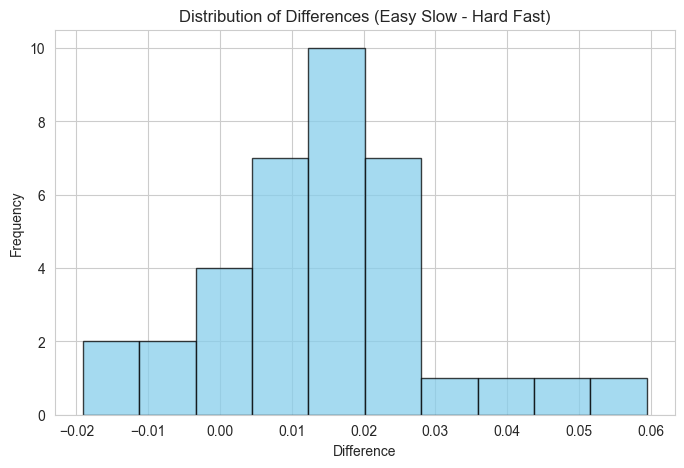

Shapiro-Wilk Test for Normality
Statistic = 0.9660, p-value = 0.3256


In [51]:
# Check Normality
pivoted_df['difference'] = pivoted_df['Easy Slow'] - pivoted_df['Hard Fast']

plt.figure(figsize=(8, 5))
plt.hist(pivoted_df['difference'], bins=10, alpha=0.75, color='skyblue', edgecolor='black')
plt.title('Distribution of Differences (Easy Slow - Hard Fast)')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

stat, p_value = stats.shapiro(pivoted_df['difference'])
print("Shapiro-Wilk Test for Normality")
print(f"Statistic = {stat:.4f}, p-value = {p_value:.4f}")

In [52]:
# Paired t-tests
visf_stat, visf_p_value = ttest_rel(pivoted_df['Easy Slow'], pivoted_df['Hard Fast'])
print(f"Paired t-test Results:\nt-statistic = {visf_stat:.4f}, p-value = {visf_p_value}")

Paired t-test Results:
t-statistic = 5.3785, p-value = 5.097717975501477e-06


##### Visit Length - Description
Significant

In [53]:
# Prepare Dataset
col = 'visit_len_Description'
aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'instance'])[col].mean().reset_index()
pivoted_df = aggregated_df.pivot(index=['participant_id', 'instance'], columns='condition', values=col).reset_index()
pivoted_df.columns.name = ''

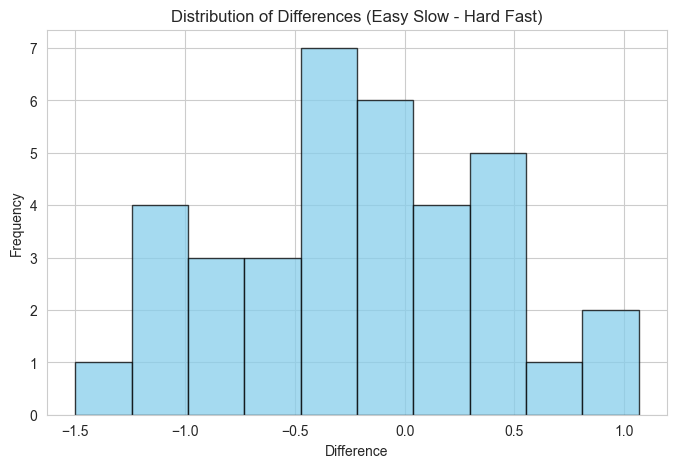

Shapiro-Wilk Test for Normality
Statistic = 0.9872, p-value = 0.9439


In [54]:
# Check Normality
pivoted_df['difference'] = pivoted_df['Easy Slow'] - pivoted_df['Hard Fast']

plt.figure(figsize=(8, 5))
plt.hist(pivoted_df['difference'], bins=10, alpha=0.75, color='skyblue', edgecolor='black')
plt.title('Distribution of Differences (Easy Slow - Hard Fast)')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

stat, p_value = stats.shapiro(pivoted_df['difference'])
print("Shapiro-Wilk Test for Normality")
print(f"Statistic = {stat:.4f}, p-value = {p_value:.4f}")

In [55]:
# Paired t-tests
visl_stat, visl_p_value = ttest_rel(pivoted_df['Easy Slow'], pivoted_df['Hard Fast'])
print(f"Paired t-test Results:\nt-statistic = {visl_stat:.4f}, p-value = {visl_p_value}")

Paired t-test Results:
t-statistic = -2.0329, p-value = 0.04970238462585342


##### Dwell_time - Ticket
Significant

In [56]:
# Prepare Dataset
col = 'dwell_pct_Ticket'
aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'instance'])[col].mean().reset_index()
pivoted_df = aggregated_df.pivot(index=['participant_id', 'instance'], columns='condition', values=col).reset_index()
pivoted_df.columns.name = ''

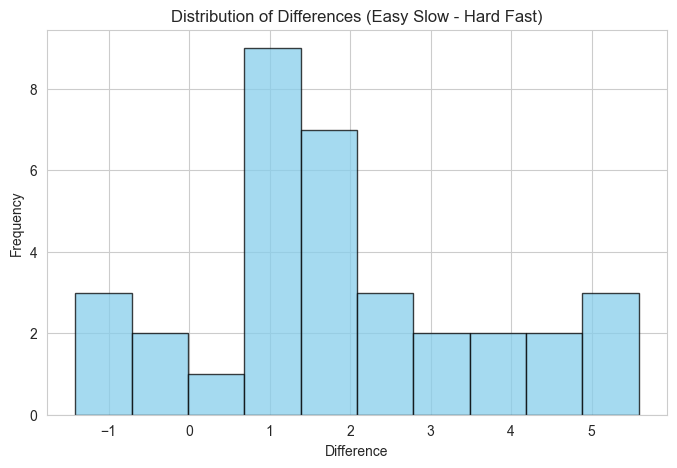

Shapiro-Wilk Test for Normality
Statistic = 0.9570, p-value = 0.1991


In [57]:
# Check Normality
pivoted_df['difference'] = pivoted_df['Easy Slow'] - pivoted_df['Hard Fast']
pivoted_df = pivoted_df[abs(pivoted_df['difference']) <= 8]

plt.figure(figsize=(8, 5))
plt.hist(pivoted_df['difference'], bins=10, alpha=0.75, color='skyblue', edgecolor='black')
plt.title('Distribution of Differences (Easy Slow - Hard Fast)')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

stat, p_value = stats.shapiro(pivoted_df['difference'])
print("Shapiro-Wilk Test for Normality")
print(f"Statistic = {stat:.4f}, p-value = {p_value:.4f}")

In [58]:
# Paired t-tests
dwell_stat, dwell_p_value = ttest_rel(pivoted_df['Easy Slow'], pivoted_df['Hard Fast'])
print(f"Paired t-test Results:\nt-statistic = {dwell_stat:.4f}, p-value = {dwell_p_value}")

Paired t-test Results:
t-statistic = 6.0095, p-value = 9.380693588587804e-07


##### Stationary Entropy
Significant

In [59]:
# Prepare Dataset
col = 'stat_entropy'
aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'instance'])[col].mean().reset_index()
pivoted_df = aggregated_df.pivot(index=['participant_id', 'instance'], columns='condition', values=col).reset_index()
pivoted_df.columns.name = ''

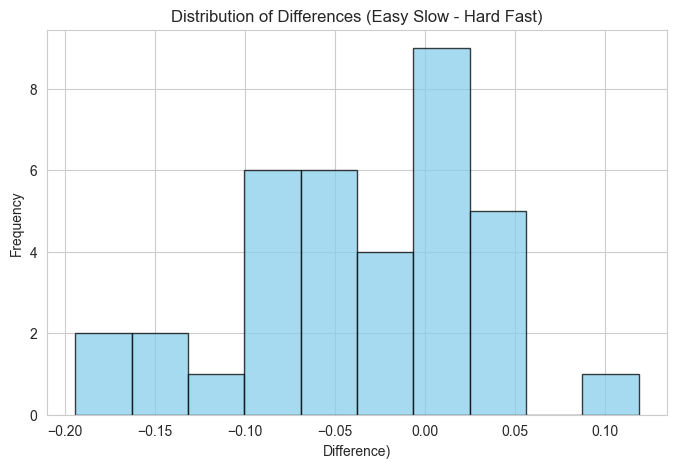

Shapiro-Wilk Test for Normality
Statistic = 0.9775, p-value = 0.6588


In [60]:
# Check Normality
pivoted_df['difference'] = pivoted_df['Easy Slow'] - pivoted_df['Hard Fast']

plt.figure(figsize=(8, 5))
plt.hist(pivoted_df['difference'], bins=10, alpha=0.75, color='skyblue', edgecolor='black')
plt.title('Distribution of Differences (Easy Slow - Hard Fast)')
plt.xlabel('Difference)')
plt.ylabel('Frequency')
plt.show()

stat, p_value = stats.shapiro(pivoted_df['difference'])
print("Shapiro-Wilk Test for Normality")
print(f"Statistic = {stat:.4f}, p-value = {p_value:.4f}")

In [61]:
# Paired t-tests
sentr_stat, sentr_p_value = ttest_rel(pivoted_df['Easy Slow'], pivoted_df['Hard Fast'])
print(f"Paired t-test Results:\nt-statistic = {sentr_stat:.4f}, p-value = {sentr_p_value}")

Paired t-test Results:
t-statistic = -3.4104, p-value = 0.0016499057597239722


### 4. Results

In [63]:
# Build table
ttest_data = {
    'Metric': ['Fix Duration', 'Fix Frequency', 'Time-to-1st Fix', 'Visit Frequency', 'Dwell Time', 'Stat Entropy'],
    'Area': ['Description', 'Actions', 'Actions', 'Ticket', 'Ticket', '-'],
    'Hypothesis': ['Positive', 'Positive', '(*)Positive', '(*)Negative', 'Positive', 'Negative'],
    'Relation': ['Negative', 'Positive', 'Negative', 'Negative', 'Negative', 'Positive'],
    'p-value': [dur_p_value, fixf_p_value, ttff_p_value, visf_p_value, dwell_p_value, sentr_p_value],
    '': [' **', '***', '  -', '***', '***', ' **'],
}

df_ttest = pd.DataFrame(ttest_data)

df_ttest.style.format({
    ('p-value'): lambda x: "{:.1e}".format(x) if x < 0.001 else "{:.4f}".format(x),
}).set_caption("Combined two-sided paired T-Test Results for RQ1")


,Metric,Area,Hypothesis,Relation,p-value,
0,Fix Duration,Description,Positive,Negative,0.0024,**
1,Fix Frequency,Actions,Positive,Positive,5.5e-06,***
2,Time-to-1st Fix,Actions,(*)Positive,Negative,0.0508,-
3,Visit Frequency,Ticket,(*)Negative,Negative,5.1e-06,***
4,Dwell Time,Ticket,Positive,Negative,9.4e-07,***
5,Stat Entropy,-,Negative,Positive,0.0016,**


### 5. Discussion

Descriptive Analysis of other AoI

##### Fix Duration

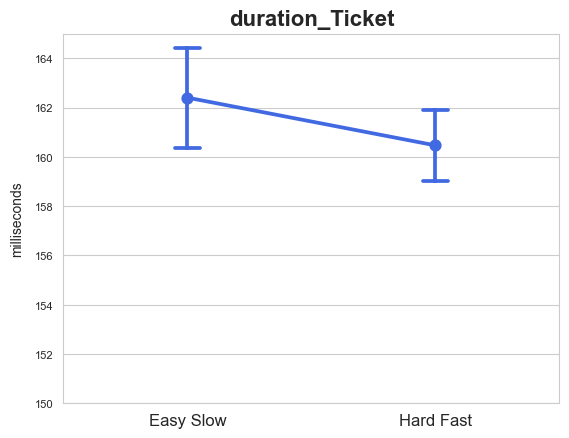

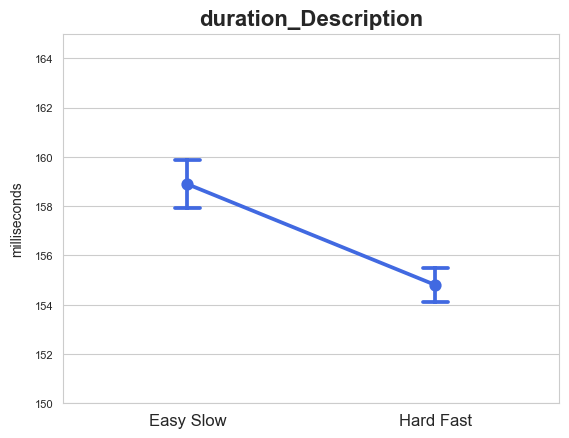

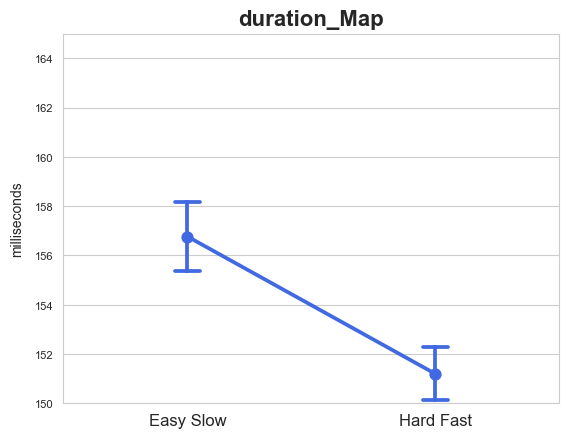

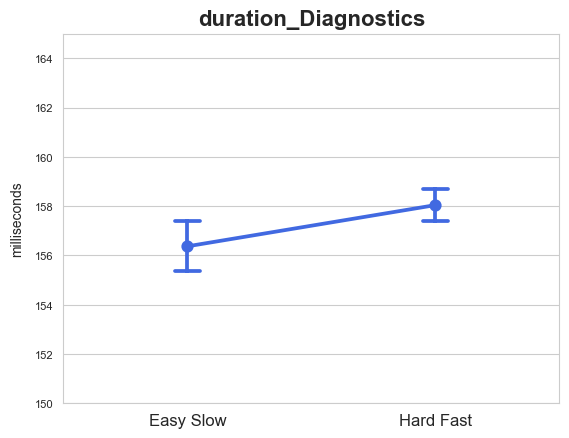

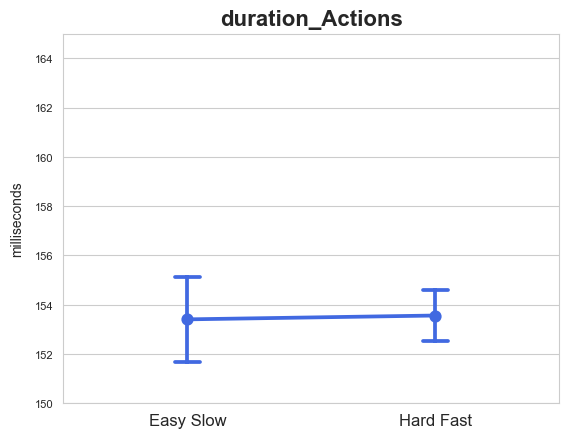

In [64]:
# Visualize plot
sns.set_style("whitegrid")
for col in ['duration_Ticket', 'duration_Description', 'duration_Map', 'duration_Diagnostics', 'duration_Actions', ]:
    plt.title(f'{col}', fontsize=16, weight='bold')
    sns.pointplot(data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color='#4169E1')
    plt.xlabel('')
    plt.ylabel('milliseconds', fontsize=10, labelpad=8)
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=8)
    plt.ylim(150, 165)
    plt.xticks(ticks=[0, 1], labels=['Easy Slow', 'Hard Fast'])
    plt.show()

##### Time-to-1st Fix

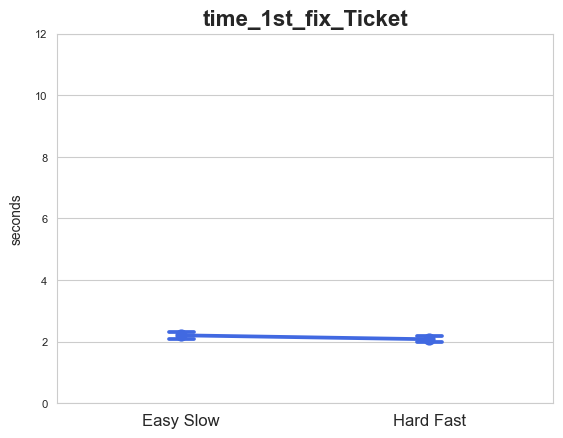

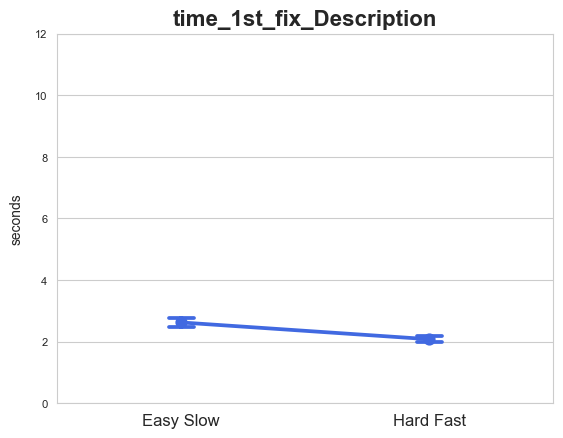

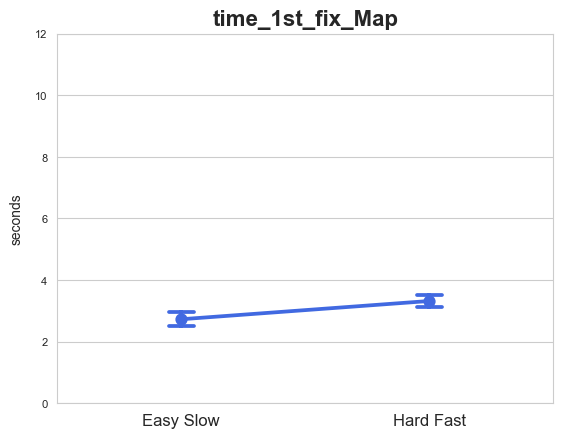

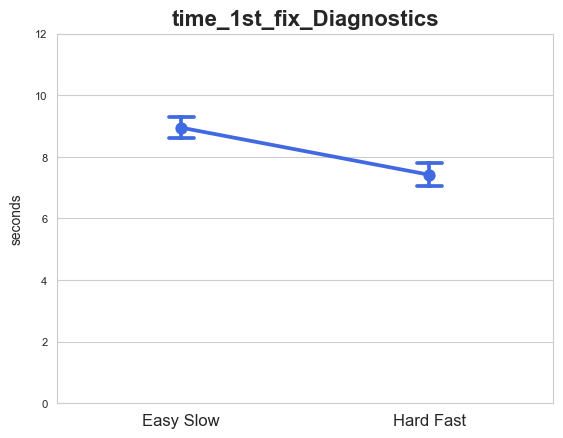

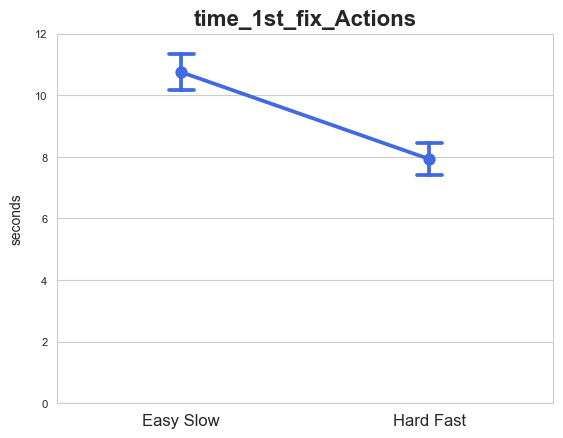

In [65]:
# Visualize plot
sns.set_style("whitegrid")
for col in ['time_1st_fix_Ticket', 'time_1st_fix_Description', 'time_1st_fix_Map', 'time_1st_fix_Diagnostics', 'time_1st_fix_Actions', ]:
    plt.title(f'{col}', fontsize=16, weight='bold')
    sns.set_style("whitegrid")
    sns.pointplot(data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color='#4169E1')
    plt.xlabel('')
    plt.ylabel('seconds', fontsize=10, labelpad=8)
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=8)
    plt.ylim(0, 12)
    plt.xticks(ticks=[0, 1], labels=['Easy Slow', 'Hard Fast'])
    plt.show()

##### Dwell Time

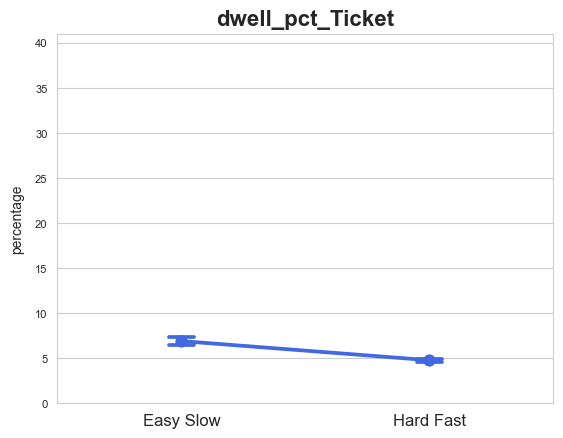

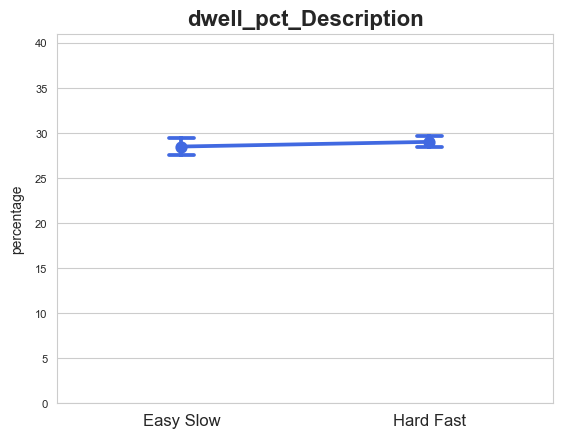

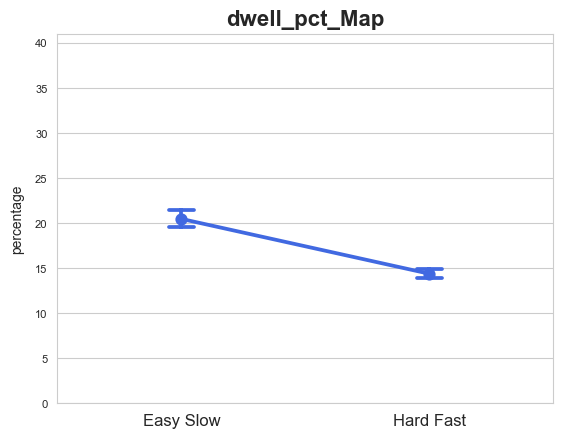

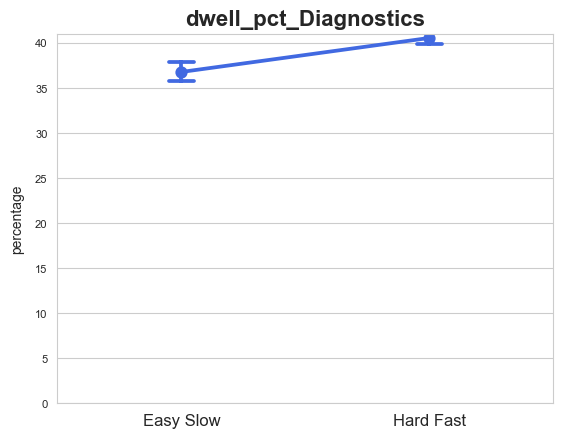

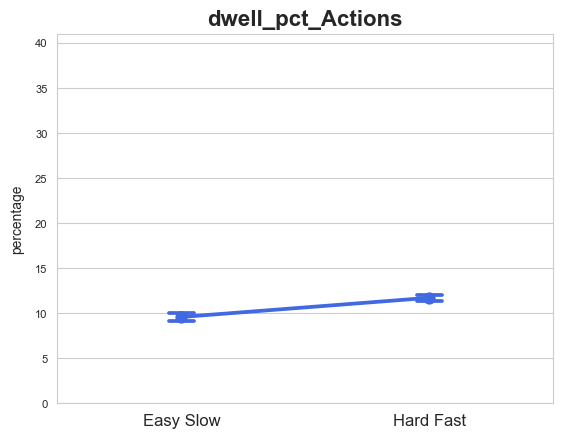

In [66]:
# Visualize plot
sns.set_style("whitegrid")
for col in ['dwell_pct_Ticket', 'dwell_pct_Description', 'dwell_pct_Map', 'dwell_pct_Diagnostics', 'dwell_pct_Actions', ]:
    plt.title(f'{col}', fontsize=16, weight='bold')
    sns.set_style("whitegrid")
    sns.pointplot(data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color='#4169E1')
    plt.xlabel('')
    plt.ylabel('percentage', fontsize=10, labelpad=8)
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=8)
    plt.ylim(0, 41)
    plt.xticks(ticks=[0, 1], labels=['Easy Slow', 'Hard Fast'])
    plt.show()